# exp009

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
import xgboost as xgb

sns.set_style("darkgrid")
%matplotlib inline

## 実験設定

In [12]:
class CONFIG:
    seed = 42
    n_splits = 5
    num_boost_round = 10000
    early_stopping_rounds = 10
    learning_rate = 0.01
    objective = "regression"
    num_leaves = 32
    period = 1000
    exp_id = "009"
    model_path = Path(f"../output/model{exp_id}")
    model_path.mkdir(parents=True, exist_ok=True)
    submission_path = Path(f"../output/submission")

## データセットの読み込み

In [13]:
input_path = Path("../input")

train_df = pd.read_parquet(input_path / "train.parquet")
test_df = pd.read_parquet(input_path / "test.parquet")

## RMSLEの定義

In [14]:
def feval_rmsle(preds, data):
    y_true = data.get_label()
    preds = np.clip(preds, 0, None)  # 0より小さい値を0に置換
    rmsle = np.sqrt(mean_squared_log_error(y_true, preds))
    return 'RMSLE', rmsle, False

## 特徴量エンジニアリング

In [15]:
df = pd.concat([train_df, test_df], axis=0, sort=False).reset_index(drop=True)
df = df.drop(["casual", "registered"], axis=1)

In [16]:
datetime = pd.to_datetime(df["datetime"])
df["year"] = datetime.dt.year
df["month"] = datetime.dt.month
df["day"] = datetime.dt.day
df["hour"] = datetime.dt.hour
df["dayofweek"] = datetime.dt.day_name()
df["dayofweek"] = df["dayofweek"].map({"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6})
df = df.drop("datetime", axis=1)

In [17]:
df["count"] = df["count"].apply(lambda x: np.log(x))

In [18]:
df['peak'] = df[['hour', 'workingday']].apply(lambda x: 1 if (x['workingday'] == 1 and (x['hour'] == 8 or 17 <= x['hour'] <= 18  or 12 <= x['hour'] <= 13)) \
                                        or (x['workingday'] == 0 and 10 <= x['hour'] <= 19) else 0, axis=1)

In [19]:
train_df = df[~df["count"].isnull()].reset_index(drop=True)
test_df = df[df["count"].isnull()].drop("count", axis=1).reset_index(drop=True)

## LightGBM train

In [20]:
def lgb_train(df, model_path):
    kf = KFold(n_splits=CONFIG.n_splits, shuffle=True, random_state=CONFIG.seed)
    fold_rmsles = []

    for fold, (train_index, valid_index) in enumerate(kf.split(df)):
        print(f"start training for fold {fold}")

        X_train = df.iloc[train_index].drop(["count"], axis=1)
        y_train = df.iloc[train_index]["count"]

        X_valid = df.iloc[valid_index].drop(["count"], axis=1)
        y_valid = df.iloc[valid_index]["count"]

        print("start training")
        params = {
            "objective": CONFIG.objective,
            "seed": CONFIG.seed,
            "learning_rate": CONFIG.learning_rate,
            "num_leaves": CONFIG.num_leaves,
        }

        train_set = lgb.Dataset(X_train, y_train)
        valid_set = lgb.Dataset(X_valid, y_valid, reference=train_set)

        model = lgb.train(
            params=params,
            train_set=train_set,
            valid_sets=[train_set, valid_set],
            num_boost_round=CONFIG.num_boost_round,
            feval=feval_rmsle,
            callbacks=[
                lgb.early_stopping(stopping_rounds=CONFIG.early_stopping_rounds, verbose=True),
                lgb.log_evaluation(period=CONFIG.period)
            ]
        )

        print(f"predict valid for fold {fold}")
        y_pred = model.predict(X_valid)
        y_pred = np.clip(y_pred, 0, None)
        y_pred = np.exp(y_pred)
        y_valid = np.exp(y_valid)

        fold_rmsles.append(np.sqrt(mean_squared_log_error(y_valid, y_pred)))

        print(f"save model for fold {fold}")
        model.save_model(model_path / f"lgb_model_fold{fold+1:03d}.bin", num_iteration=model.best_iteration)

    return sum(fold_rmsles) / len(fold_rmsles)

In [21]:
train_rmsle = lgb_train(train_df, CONFIG.model_path)
print(f"LightGBM RMSLE: {train_rmsle}")

start training for fold 0
start training
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 8708, number of used features: 14
[LightGBM] [Info] Start training from score 4.555325
Training until validation scores don't improve for 10 rounds
[1000]	training's l2: 0.0676553	training's RMSLE: 0.0905109	valid_1's l2: 0.102447	valid_1's RMSLE: 0.109718
Early stopping, best iteration is:
[1080]	training's l2: 0.0656106	training's RMSLE: 0.0893246	valid_1's l2: 0.101542	valid_1's RMSLE: 0.109486
predict valid for fold 0
save model for fold 0
start training for fold 1
start training
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the o

## XGBoost train

In [32]:
def xgb_train(df, model_path):
    kf = KFold(n_splits=CONFIG.n_splits, shuffle=True, random_state=CONFIG.seed)
    fold_rmsles = []

    for fold, (train_index, valid_index) in enumerate(kf.split(df)):
        print(f"start training for fold {fold}")

        X_train = df.iloc[train_index].drop(["count"], axis=1)
        y_train = df.iloc[train_index]["count"]

        X_valid = df.iloc[valid_index].drop(["count"], axis=1)
        y_valid = df.iloc[valid_index]["count"]

        print("start training")
        params = {
            "objective": "reg:squarederror",
            "seed": CONFIG.seed,
            "learning_rate": CONFIG.learning_rate,
        }

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)

        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            evals=watchlist,
            num_boost_round=CONFIG.num_boost_round,
            early_stopping_rounds=CONFIG.early_stopping_rounds,
            verbose_eval=CONFIG.period
        )

        print(f"predict valid for fold {fold}")
        y_pred = model.predict(dvalid)
        y_pred = np.clip(y_pred, 0, None)
        y_pred = np.exp(y_pred)
        y_valid = np.exp(y_valid)

        fold_rmsles.append(np.sqrt(mean_squared_log_error(y_valid, y_pred)))

        print(f"save model for fold {fold}")
        model.save_model(model_path / f"xgb_model_fold{fold+1:03d}.bin")

    return sum(fold_rmsles) / len(fold_rmsles)

In [33]:
train_rmsle = xgb_train(train_df, CONFIG.model_path)
print(f"XGBoost RMSLE: {train_rmsle}")

start training for fold 0
start training
[0]	train-rmse:1.47153	valid-rmse:1.49394


[1000]	train-rmse:0.24257	valid-rmse:0.31951
[1177]	train-rmse:0.23621	valid-rmse:0.31841
predict valid for fold 0
save model for fold 0
start training for fold 1
start training
[0]	train-rmse:1.48133	valid-rmse:1.45497


c:\Users\Jun\Desktop\bike-sharing-demand\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [10:18:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


[1000]	train-rmse:0.24061	valid-rmse:0.30751
[1749]	train-rmse:0.21227	valid-rmse:0.30170
predict valid for fold 1
save model for fold 1
start training for fold 2
start training
[0]	train-rmse:1.47318	valid-rmse:1.48733


c:\Users\Jun\Desktop\bike-sharing-demand\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [10:18:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


[1000]	train-rmse:0.23890	valid-rmse:0.32247
[1377]	train-rmse:0.22075	valid-rmse:0.31785
predict valid for fold 2
save model for fold 2
start training for fold 3
start training
[0]	train-rmse:1.48620	valid-rmse:1.43517


c:\Users\Jun\Desktop\bike-sharing-demand\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [10:18:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


[1000]	train-rmse:0.24275	valid-rmse:0.31568
[1204]	train-rmse:0.23356	valid-rmse:0.31388
predict valid for fold 3
save model for fold 3
start training for fold 4
start training
[0]	train-rmse:1.46757	valid-rmse:1.50949


c:\Users\Jun\Desktop\bike-sharing-demand\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [10:18:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


[1000]	train-rmse:0.24049	valid-rmse:0.31526
[1179]	train-rmse:0.23282	valid-rmse:0.31352
predict valid for fold 4
save model for fold 4
XGBoost RMSLE: 0.2826146496758605


c:\Users\Jun\Desktop\bike-sharing-demand\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [10:18:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


## LightGBM evaluate

In [23]:
def lgb_evaluate(df, model_path):
    predictions = []

    for fold in range(CONFIG.n_splits):
        print(f"loading model for fold {fold}")
        model = lgb.Booster(model_file=model_path / f"lgb_model_fold{fold+1:03d}.bin")

        print(f"start evaluate for fold {fold}")
        X_test = df.copy()

        print(f"predict test for fold {fold}")
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_pred = np.clip(y_pred, 0, None)
        y_pred = np.exp(y_pred)
        predictions.append(y_pred)
    
    average_predictions = np.mean(predictions, axis=0)
    return average_predictions

In [24]:
y_pred_lgb = lgb_evaluate(test_df, CONFIG.model_path)
y_pred_lgb

loading model for fold 0
start evaluate for fold 0
predict test for fold 0
loading model for fold 1
start evaluate for fold 1
predict test for fold 1
loading model for fold 2
start evaluate for fold 2
predict test for fold 2
loading model for fold 3
start evaluate for fold 3
predict test for fold 3
loading model for fold 4
start evaluate for fold 4
predict test for fold 4


array([  9.69808185,   5.11889934,   3.19136583, ..., 126.64077748,
        96.1577877 ,  57.22893167])

## XGBoost evaluate

In [43]:
def xgb_evaluate(df, model_path):
    predictions = []

    for fold in range(CONFIG.n_splits):
        print(f"loading model for fold {fold}")
        model = xgb.Booster(model_file=model_path / f"xgb_model_fold{fold+1:03d}.bin")

        print(f"start evaluate for fold {fold}")
        dtest = xgb.DMatrix(df)

        print(f"predict test for fold {fold}")
        y_pred = model.predict(dtest)
        y_pred = np.clip(y_pred, 0, None)
        y_pred = np.exp(y_pred)
        predictions.append(y_pred)

    average_predictions = np.mean(predictions, axis=0)
    return average_predictions

In [44]:
y_pred_xgb = xgb_evaluate(test_df, CONFIG.model_path)
y_pred_xgb

loading model for fold 0
start evaluate for fold 0
predict test for fold 0
loading model for fold 1
start evaluate for fold 1
predict test for fold 1
loading model for fold 2
start evaluate for fold 2
predict test for fold 2
loading model for fold 3
start evaluate for fold 3
predict test for fold 3
loading model for fold 4
start evaluate for fold 4
predict test for fold 4


array([ 10.222393 ,   4.9416137,   3.446795 , ..., 121.045555 ,
        94.42409  ,  51.65867  ], dtype=float32)

## アンサンブル

In [51]:
y_pred = 0.5*y_pred_lgb + 0.5*y_pred_xgb
y_pred

array([  9.96023744,   5.03025651,   3.31908041, ..., 123.8431663 ,
        95.29093761,  54.44380009])

In [52]:
submission = pd.read_csv(input_path / "sampleSubmission.csv")
submission["count"] = y_pred
submission.to_csv(CONFIG.submission_path / f"submission{CONFIG.exp_id}.csv", index=False)

## Result

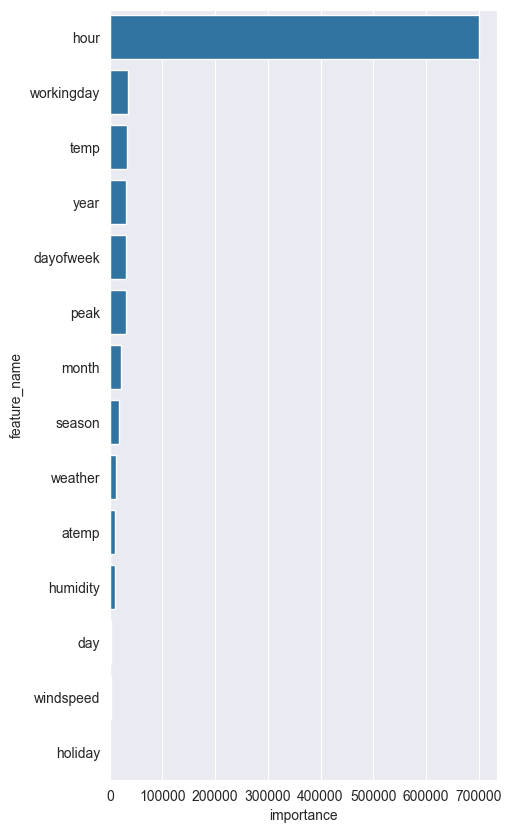

In [50]:
model = lgb.Booster(model_file=CONFIG.model_path / f"lgb_model_fold001.bin")
importance_df = pd.DataFrame()

importance_df["importance"] = model.feature_importance(importance_type="gain")
importance_df["feature_name"] = model.feature_name()
importance_df = importance_df.sort_values("importance", ascending=False)

fig = plt.figure(figsize=(5, 10))
sns.barplot(data=importance_df, x="importance", y="feature_name")
plt.show()